# TP 2  Linear regression

```yaml
Date: Jan 31 2024
Name: Liyao JIAO
```

In [55]:
fn1 = "Liyao"
ln1 = "JIAO"
filename = "_".join(map(lambda s: s.strip().lower(),
["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
print(f"filename: {filename}")

filename: sd-tsia204_lab2_jiao_liyao.ipynb


In [254]:
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, 
    Ridge, 
    ElasticNet,
)
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import numpy as np

from typing import List, Tuple, Union, Optional, Any
import pandas as pd

from scipy.stats import norm, t


# GLOBAL SETTING
SEED = 42
np.random.seed(SEED)

In [59]:
def split_line():
    print("{:=^50s}".format("Split Line"))

---

## 1 California Housing

### 1.a 

In [20]:
# load data as frame
california_housing = fetch_california_housing(as_frame=True)

In [31]:
"""
:Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude
"""
california_housing.frame.info()
split_line()
california_housing.frame.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
====================Split Line====================


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


/tmp/ipykernel_6066/1184810459.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.7, wspace=0.4)


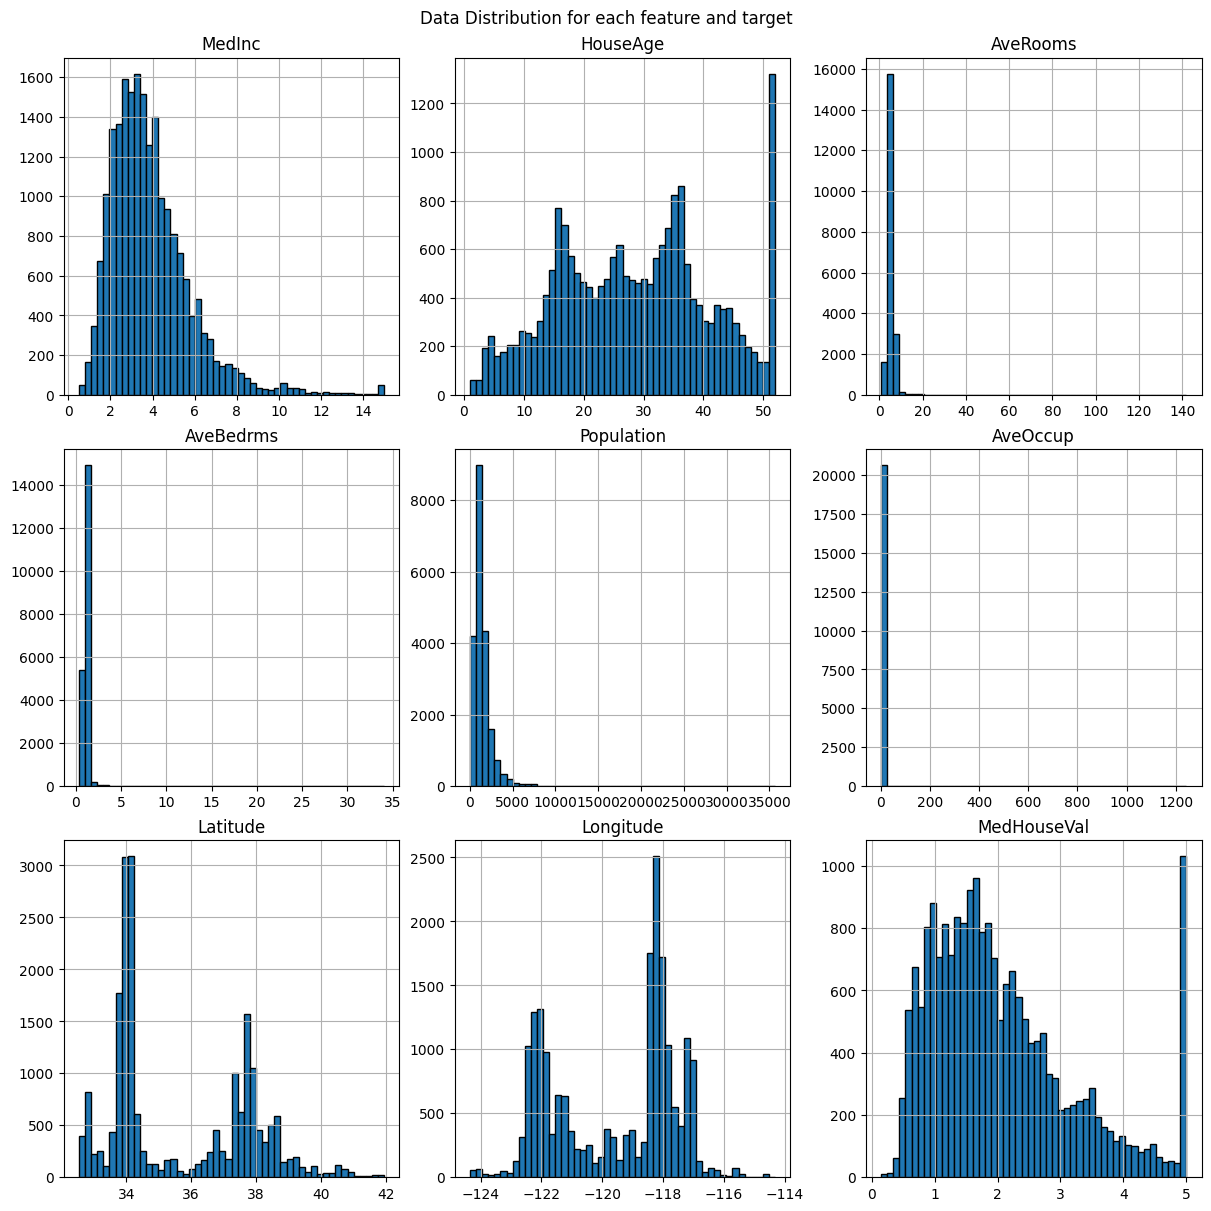

In [42]:
california_housing.frame.hist(figsize=(12, 12), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.suptitle("Data Distribution for each feature and target")
plt.rcParams['figure.constrained_layout.use'] = True


---
**What we do next :**

1. Preprocess dataset
2. Use normal equation for calculating coefficient
3. Code two functions `MSE`, `R2`
4. Do thing above by `sklearn`
5. Compare the results of two methods

**Normal Equation :**

$$
\begin{align*}
X^\mathsf{T}X \hat{\theta} &= X^\mathsf{T} y \\
\hat{\theta} &= (X^\mathsf{T}X)^{-1} X^\mathsf{T} y

\end{align*}
$$

In [100]:
### 1/5: Preprocess:
X0 = california_housing.data.to_numpy()
y0 = california_housing.target.to_numpy()
y0 = y0.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X0, y0, test_size=0.2, random_state=SEED
)
print(f"Train set size: {X_train.shape[0]}; Test set size: {X_test.shape[0]}")


Train set size: 16512; Test set size: 4128


In [101]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

Text(0.5, 1.0, 'MedHouseVal')

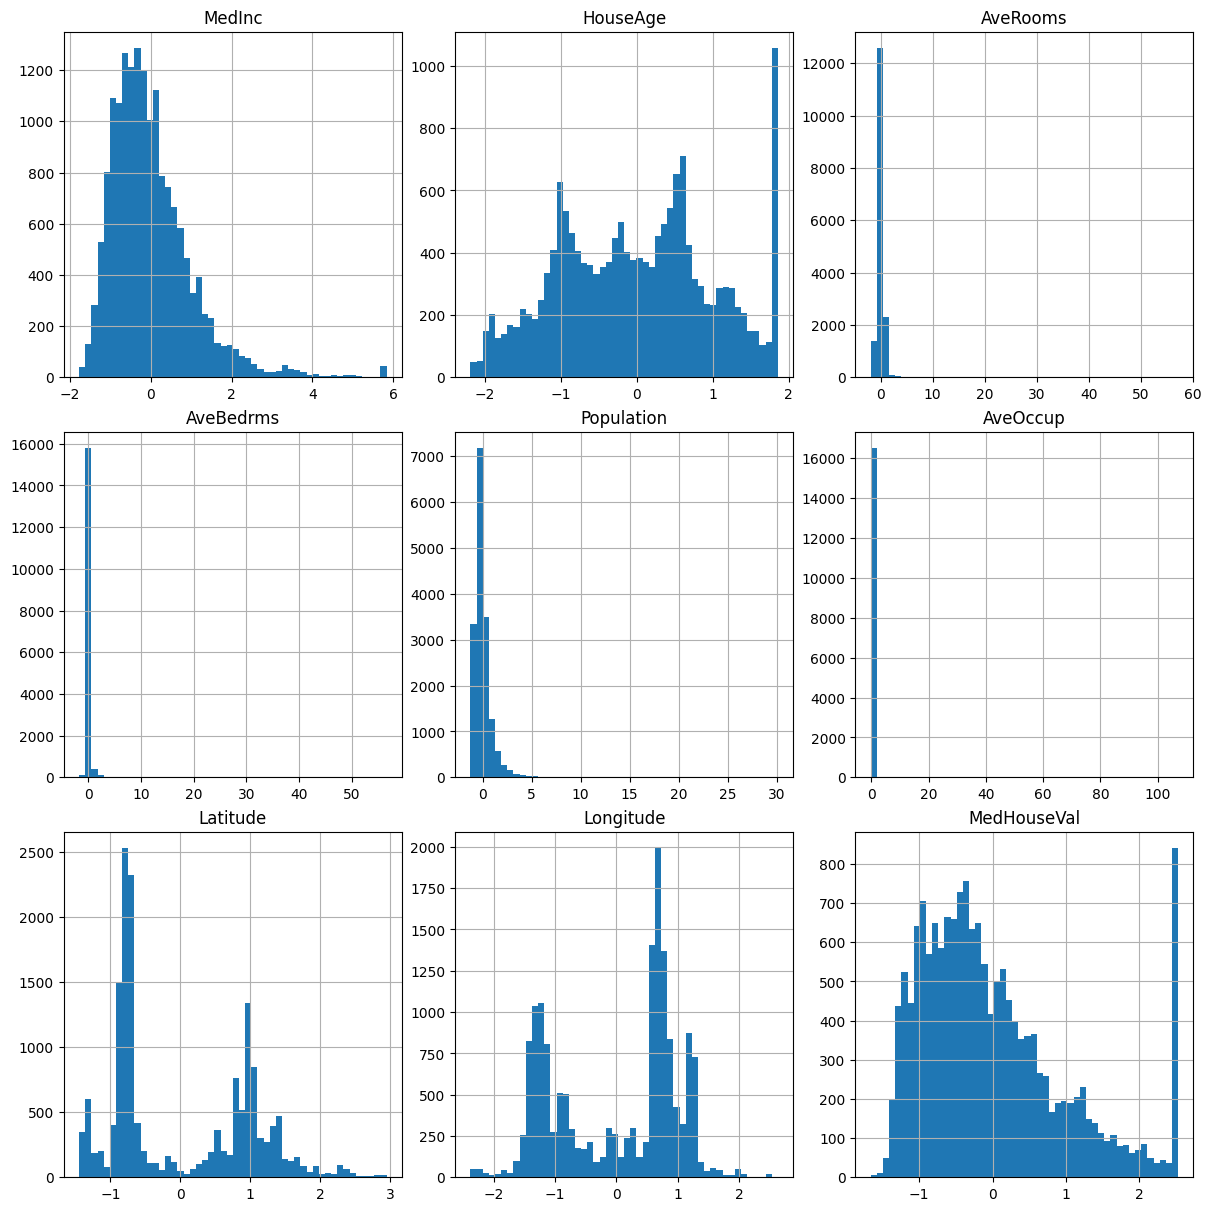

In [102]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True)

axsf = axs.flatten()

# new distribution of feature
for i in range(X_train.shape[1]):
    axsf[i].hist(X_train[:,i], bins=50)
    axsf[i].set_title(california_housing.feature_names[i])
    axsf[i].grid()

# for target
i += 1
axsf[i].hist(y_train, bins=50)
axsf[i].grid()
axsf[i].set_title(california_housing.target_names[0])

In [213]:
### 2/5: Normal equation
def get_coefficients_by_normal_equation(X_train: np.ndarray, y_train: np.ndarray) -> np.ndarray :
    a = np.ones(shape=(X_train.shape[0], 1))
    X = np.column_stack([a, X_train])
    return np.linalg.inv(X.T @ X) @ X.T @ y_train

def MSE(a, b):
    return np.mean((a-b)**2)

def R2(y1, y2):
    return 1 - np.sum((y1-y2)**2) / np.sum((y1-y1.mean())**2)


In [214]:
hat_theta = get_coefficients_by_normal_equation(X_train=X_train, y_train=y_train)

In [215]:
X_train_design =  np.column_stack([np.ones(shape=(X_train.shape[0], 1)), X_train])
hat_y = X_train_design @ hat_theta

In [216]:
def visualize_prediction(X_train, y_train, X_test, y_test, theta, intercept=False):
    L = X_train.shape[0]
    L1 = X_test.shape[0]

    if intercept:
        X_train_design =  np.column_stack([np.ones(shape=(X_train.shape[0], 1)), X_train])
        X_test_design =  np.column_stack([np.ones(shape=(X_test.shape[0], 1)), X_test])
    else:
        X_train_design = X_train
        X_test_design = X_test
        
    # 0 indicate training; 1 for testing
    arrIndex0 = np.argsort(y_train, axis=0)
    X0 = X_train_design[arrIndex0]
    y0 = y_train[arrIndex0].squeeze()
    y0_hat = X0 @ theta
    diff0 = y0_hat - y0
    mse_train = MSE(y0, y0_hat)
    # r2_train = r2_score(y0.ravel(), y0_hat.ravel())
    r2_train = R2(y0.ravel(), y0_hat.ravel())

    arrIndex1 = np.argsort(y_test, axis=0)
    X1 = X_test_design[arrIndex1]
    y1 = y_test[arrIndex1]
    y1_hat = X1 @ theta
    diff1 = y1_hat - y1
    mse_test = MSE(y1, y1_hat)
    # r2_test = r2_score(y1.ravel(), y1_hat.ravel())
    r2_test = R2(y1.ravel(), y1_hat.ravel())


    fig, axs = plt.subplots(4, 1, figsize=(10, 6), constrained_layout=True)
    axsf = axs.flatten()

    axsf[0].scatter(range(L), y0, s=2)
    axsf[0].scatter(range(L), y0_hat, s=2, alpha=0.3)
    axsf[0].set_title(f"Training mse={mse_train:.3f}, R2={r2_train:.3f}")
    axsf[0].set_xlabel("index")
    axsf[0].legend(["$y_{train}$", "$\hat{y}$"])
    axsf[0].grid()


    axsf[1].hist(diff0.ravel(), bins=1000, density=True)
    axsf[1].set_title("$\hat{y} - y$")
    axsf[1].grid()

    axsf[2].scatter(range(L1), y1, s=2)
    axsf[2].scatter(range(L1), y1_hat, s=2, alpha=0.3)
    axsf[2].set_title(f"Test mse={mse_test:.3f}, R2={r2_test:.2f}")
    axsf[2].set_xlabel("index")
    axsf[2].legend(["$y_{test}$", "$\hat{y}$"])
    axsf[2].grid()


    axsf[3].hist(diff1.ravel(), bins=1000, density=True)
    axsf[3].set_title("$\hat{y} - y$")
    axsf[3].grid()
    return fig, axs
    

Text(0.5, 0.98, 'Evaluation of coefficients from Normal Equation')

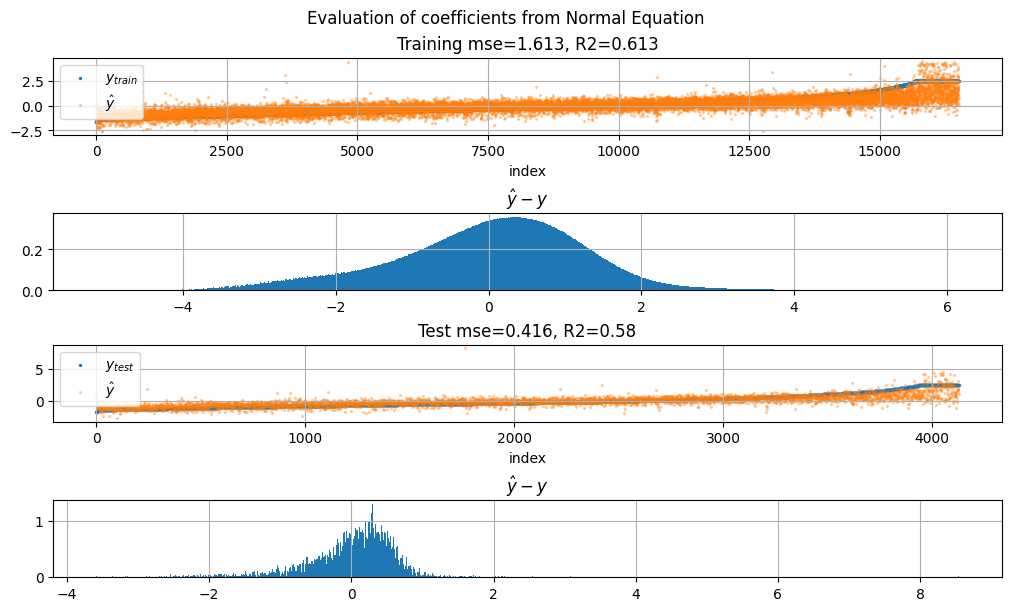

In [217]:
fig, axs = visualize_prediction(X_train, y_train, X_test, y_test, hat_theta, intercept=True)
fig.suptitle("Evaluation of coefficients from Normal Equation")

In [218]:
### 3/5 function above
# above
### 4/5 sklearn methods
model = LinearRegression()
model.fit(X_train, y_train)
theta = model.coef_.reshape(-1, 1)

Text(0.5, 0.98, 'Evaluation of coefficients from sklearn')

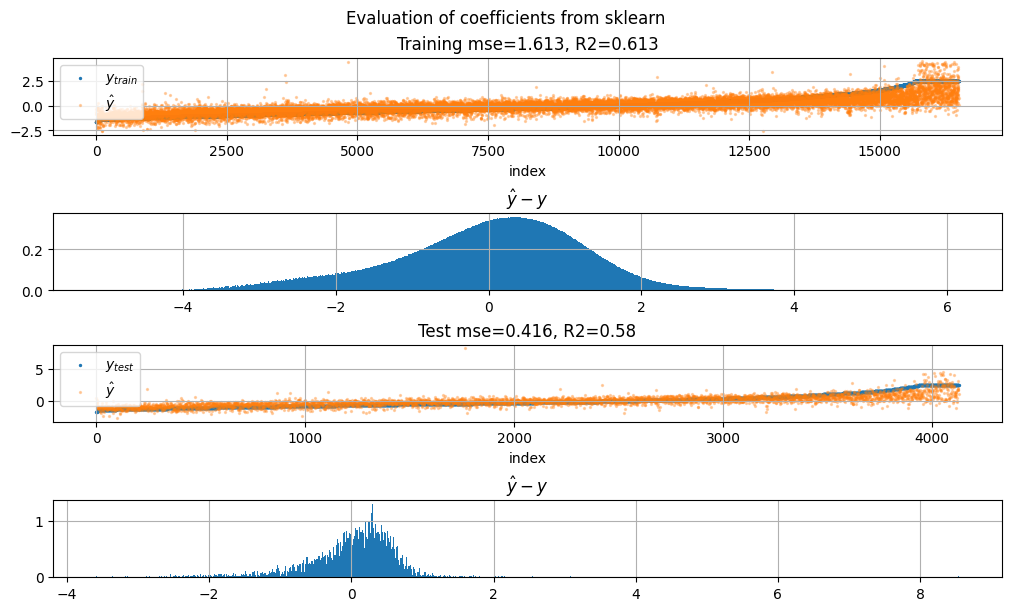

In [219]:
fig, axs = visualize_prediction(X_train, y_train, X_test, y_test, theta, intercept=False)
fig.suptitle("Evaluation of coefficients from sklearn")

**5/5 compare :**

We found that the results derived from normal equation is close to that of `sklearn`, by comparing the mse loss and $R^2$ coefficient. $\text{MSE}=1.163$, $R^2 = 0.613$ on training set and $\text{MSE}=0.416$, $R^2 = 0.58$ on test set.

### 1.b 

In [223]:
alpha=0.01
print(norm.ppf(1 - alpha/2))
print(t.ppf(1 - alpha/2, df = len(y_train) - len(hat_theta) - 1))

2.5758293035489004
2.576127272462877


In [227]:
def get_ci_4_each_coef(y, y_hat, coef, alpha=0.01):
    df = len(y) - len(coef) - 1
    t_value = t.ppf(1 - alpha/2, df=df)
    sigma_hat = np.sqrt(np.sum((y - y_hat)**2) / df)

    X_train_design =  np.column_stack([np.ones(shape=(X_train.shape[0], 1)), X_train])

    res = []

    for i, co in enumerate(coef):
        lower = co - t_value * sigma_hat * np.sqrt(np.linalg.inv(X_train_design.T @ X_train_design)[i,i])
        lower = lower[0]
        upper = co + t_value * sigma_hat * np.sqrt(np.linalg.inv(X_train_design.T @ X_train_design)[i,i])
        upper = upper[0]
        print(f"coef_{i}: [{lower}, {upper}]")
        res.append((lower, upper))
    return res

In [228]:
hat_theta.shape

(9, 1)

In [230]:
_ = get_ci_4_each_coef(y_train, hat_y, hat_theta, 0.01)

coef_0: [-0.01248263262022576, 0.012482632619780536]
coef_1: [0.719070092418756, 0.7588567285306186]
coef_2: [0.09210618134562634, 0.1198764605217407]
coef_3: [-0.2897610390112231, -0.2195147990463058]
coef_4: [0.26133771651974413, 0.3255193279925763]
coef_5: [-0.01529348293825315, 0.011301542778993524]
coef_6: [-0.04785668128448288, -0.02277022063244344]
coef_7: [-0.8136360059196065, -0.7378873685910271]
coef_8: [-0.7895228104511949, -0.7151448187938783]


---
---

## 2 OLS on `data.csv`

In [245]:
data = pd.read_csv("./data.csv", header=None)

In [246]:
data

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,-0.270323,-0.437638,0.347423,-0.123436,0.344168,-0.777434,-1.380455,0.491346,0.713854,-0.693186,...,-0.051364,-0.371945,-0.114830,0.153832,-0.973347,-0.997793,0.158006,-0.139519,1.010518,178.0
438,0.872196,0.975497,0.819331,-0.975557,-0.968388,1.029983,-0.079420,-0.130714,0.201144,-2.390860,...,-0.327924,0.350886,-0.305686,-1.292688,0.124676,1.465920,0.663206,1.278693,0.419890,104.0
439,-0.032586,-0.571893,0.806842,0.562865,1.194239,-0.345469,0.717316,0.234458,1.546961,0.554013,...,-1.467585,0.584516,-0.281854,-0.618165,0.840381,1.261452,-0.084541,0.301755,0.517624,132.0
440,-1.529754,0.756967,2.251588,-0.052600,0.502047,0.046229,-1.571494,0.238793,-1.211869,-0.896148,...,-0.000023,-2.231379,-0.880398,0.267481,1.036171,-0.962587,0.491072,-1.389069,0.473725,220.0


In [267]:
X0 = data.iloc[:, :-1].to_numpy()
y0 = data.iloc[:, -1].to_numpy()
y0 = y0.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X0, y0, test_size=0.2, random_state=0
)
print(f"Train set size: {X_train.shape[0]}; Test set size: {X_test.shape[0]}")


Train set size: 353; Test set size: 89


In [268]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [269]:
model = LinearRegression()
model.fit(X_train, y_train)
theta = model.coef_.reshape(-1, 1)

Text(0.5, 0.98, 'Evaluation of coefficients from sklearn')

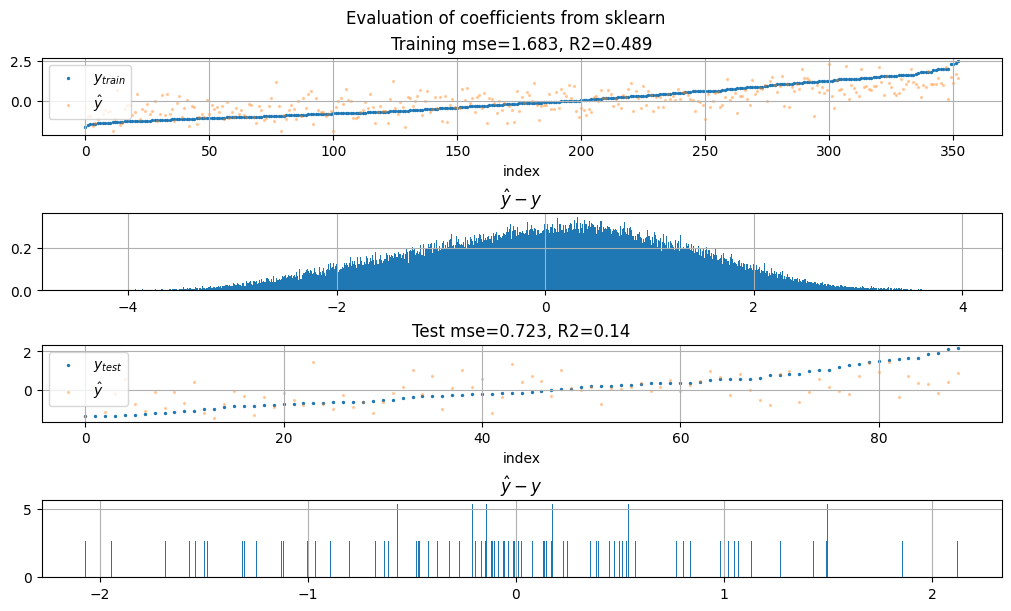

In [270]:
fig, axs = visualize_prediction(X_train, y_train, X_test, y_test, theta, intercept=False)
fig.suptitle("Evaluation of coefficients from sklearn")

---
---

## 3 Variable selection

The significance of the p-value in statistical hypothesis testing lies in its ability to provide a measure of evidence against a null hypothesis. 

In [264]:
def run_variable_selection(X, y):
    n, p = X.shape
    res = 0
    best_p = np.inf

    for i in range(p):
        x_train = X[:, i].reshape(-1, 1)
        model = LinearRegression().fit(x_train, y)

        y_hat = model.predict(X[:, i].reshape(-1, 1))
        sigma_hat = np.sqrt(np.sum((y - y_hat))**2) / (n - 2)
        tmp = (np.sqrt(n) / (np.sqrt(np.var(X[:, i])) * sigma_hat)) * np.abs(model.coef_[0])

        p = (1 - t.cdf(np.abs(tmp), df=n-2)) * 2
        if p < best_p:
            best_p = p
            res = i

    return res, best_p


In [266]:
res = []
X = X_train.copy()
y = y_train.copy()

for i in range(X.shape[1]):
    best_id, best_p = run_variable_selection(X, y)
    
    if best_p > 0.05:
        break

    res.append(best_p)

    # remove from X
    X = np.delete(X, i, axis=1)

    # subtract from y
    y_hat = model.predict(X[:, i].reshape(-1, 1))
    y = y - y_hat

/tmp/ipykernel_6066/2404387348.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  tmp = (np.sqrt(n) / (np.sqrt(np.var(X[:, i])) * sigma_hat)) * np.abs(model.coef_[0])


ValueError: X has 1 features, but LinearRegression is expecting 210 features as input.

---
---

## 4

In [282]:
def visualize_regression(X_train, y_train, X_test, y_test, penalty, Model):
    r2_train = []
    r2_test = []
    C = []

    for k in penalty:
        model = Model(alpha=k)
        
        model.fit(X_train, y_train)
        r2_train.append(model.score(X_train, y_train))
        r2_test.append(model.score(X_test, y_test))
        C.append(model.coef_)

    fig, axs = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)

    axs[0].plot(penalty, C)

    
    axs[0].set_xscale('log')
    axs[0].set_xlabel('Penalty')
    axs[0].set_title(f'Results on str(model)')

    axs[1].plot(penalty, r2_train)
    axs[1].plot(penalty, r2_test)
    axs[1].legend(["train", "test"])
    axs[1].set_xlabel('Penalty')
    axs[1].set_title(f'Results on str(model)')


ValueError: x and y can be no greater than 2D, but have shapes (30,) and (30, 1, 210)

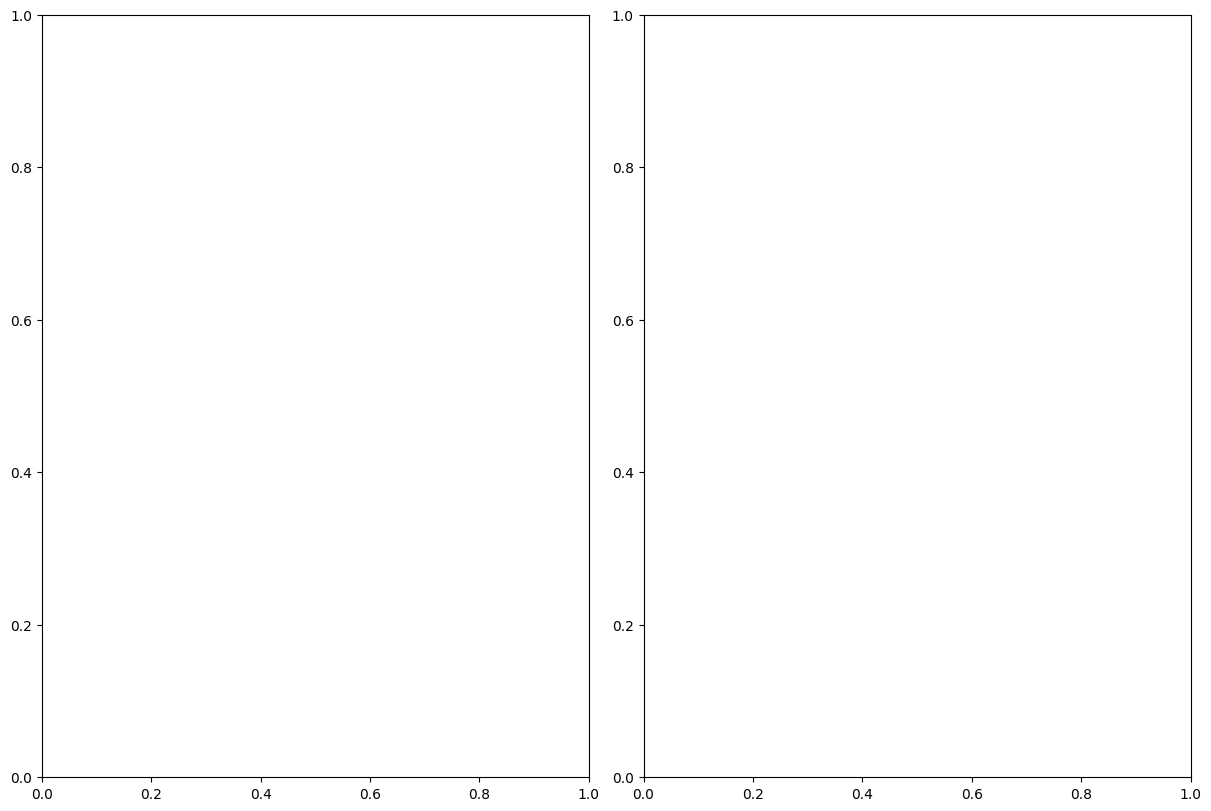

In [283]:
X_ridge = np.logspace(-1, 6, 30)

visualize_regression(X_train, y_train, X_test, y_test, X_ridge, Ridge)

---
---

## 5